# Выбор локации для скважины

<a id='section_id'></a>
## Содержание 
[1. Загрузка и подготовка данных](#section_id1)

[2. Обучение модели](#section_id2)

[____2.1. Создание обучающих и валидационных выборок](#section_id3)

[____2.2. Обучение модели, получение предсказаний](#section_id4)

[____2.3. Сохранение предсказаний и правильных ответов в валидационной выборке](#section_id5)

[____2.4. Средний запас сырья и RMSE модели](#section_id6)

[____2.5. Анализ результатов](#section_id7)

[3. Подготовка расчёта прибыли](#section_id8)

[____3.1. Сохранение ключевых значений для расчёта](#section_id9)

[____3.2. Расчёт объема сырья для безубыточной разработки. Сравнение со средним запасом в регионе](#section_id10)

[____3.3. Выводы по этапу подготовки расчёта прибыли](#section_id11)
    
[4. Определение функции для расчёта прибыли](#section_id12)

[____4.1. Выбор скважин с максимальными значениями предсказаний](#section_id13)

[____4.2. Суммирование целевого значения объема сырья](#section_id14)

[____4.3. Расчёт прибыли от полученного сырья](#section_id15)

[5. Расчёт рисков и прибыли для каждого региона](#section_id16)

[____5.1. Применение Bootstrap, поиск распределения прибыли](#section_id17)

[____5.2. Определение средней прибыли, 95% доверительного интервала и риска убытков](#section_id18)

[____5.3. Выводы. Предложение и обоснование выбора региона для разработки скважин](#section_id19)

## Описание исследования

Условной нефтедобывающей компании «ГлавРосГосНефть» нужно решить, где бурить новую скважину. 
Шаги для выбора локации обычно такие:
- В избранном регионе собирают характеристики для скважин: качество нефти и объём её запасов;
- Строят модель для предсказания объёма запасов в новых скважинах;
- Выбирают скважины с самыми высокими оценками значений;
- Определяют регион с максимальной суммарной прибылью отобранных скважин.

Предоставлены пробы нефти в трёх регионах. Характеристики для каждой скважины в регионе уже известны. Необходимо построить модель для определения региона, где добыча принесёт наибольшую прибыль. Проанализировать возможную прибыль и риски техникой Bootstrap.

## Цель исследования

Определить экономическую целесообразность разработки месторождения на основе предсказаний модели машинного обучения

## Ход исследования

1. Разработать модель машинного обучения
2. Расчитать объем сырья
3. Расчитать прибыль
4. Расчитать риски

In [ ]:
# установка библиотек
!pip install phik -q

In [1]:
# импорт библиотек для работы с данными
import pandas as pd
import numpy as np
from numpy.random import RandomState

# импорт библиотек для подготовки и обработки данных
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from phik.report import plot_correlation_matrix
from phik import phik_matrix

# импорт моделей машинного обучения
from sklearn.linear_model import LinearRegression

# импорт метрик
from sklearn.metrics import mean_squared_error

# импорт инструментов управления ресурсами
import joblib
import time

# импорт инструментов поиска
from sklearn.model_selection import GridSearchCV

# импорт графических библиотек
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [2]:
# инициализация констант
RANDOM_STATE = 42
TEST_SIZE = 0.25
STATE = RandomState(12345) 

<a id='section_id1'></a>
## 1. Загрузка и подготовка данных
[к содержанию](#section_id)

#### Загрузка данных

In [3]:
# загрузка данных для 1ого региона
geo1 = pd.read_csv('geo_data_0.csv', index_col='id')

In [4]:
# загрузка данных для 2ого региона
geo2 = pd.read_csv('geo_data_1.csv', index_col='id')

In [5]:
# загрузка данных для 3его региона
geo3 = pd.read_csv('geo_data_2.csv', index_col='id')

#### Обзор

In [6]:
# функция для обзора данных
def preview(dataset):
    '''Функция принимает на вход набор данных и выводит основную информацию о нем.'''
    display(dataset.head())
    dataset.info()
    display(dataset.describe(include='all').T)

In [7]:
# обзор данных региона 1
preview(geo1)

,f0,f1,f2,product
id,,,,
txEyH,0.705745,-0.497823,1.221170,105.280062
2acmU,1.334711,-0.340164,4.365080,73.037750
409Wp,1.022732,0.151990,1.419926,85.265647
iJLyR,-0.032172,0.139033,2.978566,168.620776
Xdl7t,1.988431,0.155413,4.751769,154.036647


<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, txEyH to 1CWhH
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.8+ MB


,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.500419,0.871832,-1.408605,-0.072580,0.502360,1.073581,2.362331
f1,100000.0,0.250143,0.504433,-0.848218,-0.200881,0.250252,0.700646,1.343769
f2,100000.0,2.502647,3.248248,-12.088328,0.287748,2.515969,4.715088,16.003790
product,100000.0,92.500000,44.288691,0.000000,56.497507,91.849972,128.564089,185.364347


In [8]:
# обзор данных региона 2
preview(geo2)

,f0,f1,f2,product
id,,,,
kBEdx,-15.001348,-8.276000,-0.005876,3.179103
62mP7,14.272088,-3.475083,0.999183,26.953261
vyE1P,6.263187,-5.948386,5.001160,134.766305
KcrkZ,-13.081196,-11.506057,4.999415,137.945408
AHL4O,12.702195,-8.147433,5.004363,134.766305


<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, kBEdx to relB0
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.8+ MB


,count,mean,std,min,25%,50%,75%,max
f0,100000.0,1.141296,8.965932,-31.609576,-6.298551,1.153055,8.621015,29.421755
f1,100000.0,-4.796579,5.119872,-26.358598,-8.267985,-4.813172,-1.332816,18.734063
f2,100000.0,2.494541,1.703572,-0.018144,1.000021,2.011479,3.999904,5.019721
product,100000.0,68.825000,45.944423,0.000000,26.953261,57.085625,107.813044,137.945408


In [9]:
# обзор данных региона 3
preview(geo3)

,f0,f1,f2,product
id,,,,
fwXo0,-1.146987,0.963328,-0.828965,27.758673
WJtFt,0.262778,0.269839,-2.530187,56.069697
ovLUW,0.194587,0.289035,-5.586433,62.871910
q6cA6,2.236060,-0.553760,0.930038,114.572842
WPMUX,-0.515993,1.716266,5.899011,149.600746


<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, fwXo0 to V9kWn
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.8+ MB


,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.002023,1.732045,-8.760004,-1.162288,0.009424,1.158535,7.238262
f1,100000.0,-0.002081,1.730417,-7.084020,-1.174820,-0.009482,1.163678,7.844801
f2,100000.0,2.495128,3.473445,-11.970335,0.130359,2.484236,4.858794,16.739402
product,100000.0,95.000000,44.749921,0.000000,59.450441,94.925613,130.595027,190.029838


В данных нет пропусков

#### Проверка на дубликаты

In [10]:
# проверка на дубликаты данных региона 1
geo1.duplicated().sum()

np.int64(0)

In [11]:
# проверка на дубликаты данных региона 2
geo2.duplicated().sum()

np.int64(0)

In [12]:
# проверка на дубликаты данных региона 3
geo3.duplicated().sum()

np.int64(0)

Типы данных определены корректно, в данных нет пропусков и дубликатов. Все признаки количественные

#### Исследовательский анализ

In [13]:
# функция для построения графиков
def plt_chart(data, cols, kind):
    '''Функция принимает в качестве аргументов датасет, названия столбцов, тип графика, строит график'''
    fig = make_subplots(cols=len(cols), rows=1, subplot_titles=cols)
    for i, c in enumerate(cols):
        if kind == 'hist':
            fig.add_trace(go.Histogram(x=data[c], nbinsx=10, name=c), row=1, col=i+1)
            fig.update_xaxes(title_text=c, row=1, col=i+1)
        if kind == 'box':
            fig.add_trace(go.Box(y=data[c], name=c), row=1, col=i+1)
    fig.update_layout(title='Признаки региона', yaxis_title='Количество')
    fig.show()

In [ ]:
# построение гистограмм по данным региона 1
data_cols = ['f0', 'f1', 'f2', 'product']

plt_chart(geo1, data_cols, 'hist')

In [ ]:
# построение гистограмм по данным региона 2
plt_chart(geo2, data_cols, 'hist')

In [ ]:
# построение гистограмм по данным региона 3
plt_chart(geo3, data_cols, 'hist')

Регион 1: f0 в диапазоне от 0 до 2.5, f1 в диапазоне от -1 до 1.5, f2 в диапазоне от -15 до 15, product от 0 до 200

Регион 2: f0 в диапазоне от -30 до 30, f1 в диапазоне от -30 до 20, f2 в диапазоне от 0 до 5, product от 0 до 150. Распределение признаков f2 и product отличается, представлено небольшим количеством значений.

Регион 3: f0 в диапазоне от -10 до 10, f1 в диапазоне от -7.5 до 7.5, f2 в диапазоне от -12 до 17, product от 0 до 200

Признаки имеют разную дисперсию в зависимости от региона, при обучении моделей необходимо использовать скейлер

#### Корреляционный анализ

In [17]:
# функция для построения тепловой карты по матрице корреляции
def plt_phik(data):
    '''Фукция принимает на вход датафрейм, строит тепловую карту по матрице корреляции.'''
    phik_overview = data.phik_matrix()

    plot_correlation_matrix(
        phik_overview.values,
        x_labels=phik_overview.columns,
        y_labels=phik_overview.index,
        figsize=(5, 5)
    )

interval columns not set, guessing: ['f0', 'f1', 'f2', 'product']


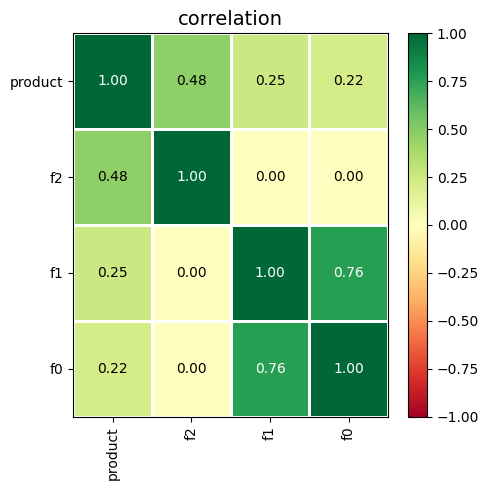

In [18]:
# построение тепловой карты по матрице корреляции для региона 1
plt_phik(geo1)

interval columns not set, guessing: ['f0', 'f1', 'f2', 'product']


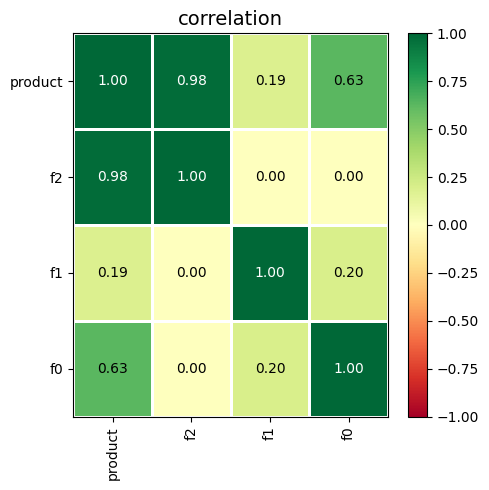

In [19]:
# построение тепловой карты по матрице корреляции для региона 2
plt_phik(geo2)

interval columns not set, guessing: ['f0', 'f1', 'f2', 'product']


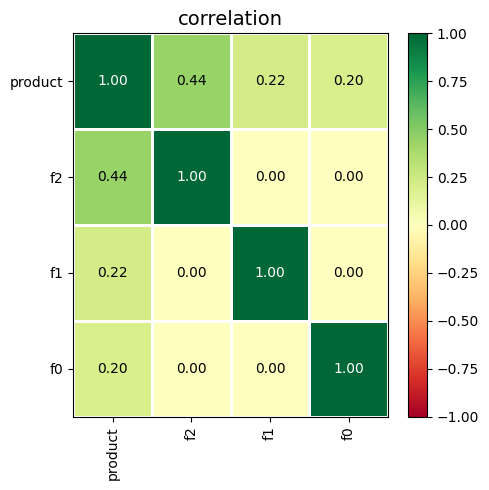

In [20]:
# построение тепловой карты по матрице корреляции для региона 3
plt_phik(geo3)

Сильнее всего целевой признак в регионе 1 и 3 коррелирует с признаком f2, в регионе 2 с f2 и f0.

Можно предположить, что признак f2 - индикатор больших объемов нефти

<a id='section_id2'></a>
## 2. Обучение модели
[к содержанию](#section_id)

<a id='section_id3'></a>
### 2.1. Создание обучающих и валидационных выборок
[к содержанию](#section_id)

In [21]:
# функция для разделения данных на тренировочную и тестовую выборки
def make_split(data):
    '''Функция принимает в качестве аргумента набор данных,
    возвращает тренировочную, тестовую выборки и значения их целевых признаков'''
    X_train, X_test, y_train, y_test = train_test_split(
        data.drop(['product'], axis=1),
        data['product'],
        test_size = TEST_SIZE, 
        random_state = RANDOM_STATE)
    
    return X_train, X_test, y_train, y_test

In [22]:
# создание тренировочной и тестовой выборки региона 1
X_train1, X_test1, y_train1, y_test1 = make_split(geo1)
X_train1.shape, X_test1.shape

((75000, 3), (25000, 3))

In [23]:
# создание тренировочной и тестовой выборки региона 2
X_train2, X_test2, y_train2, y_test2 = make_split(geo2)
X_train2.shape, X_test2.shape

((75000, 3), (25000, 3))

In [24]:
# создание тренировочной и тестовой выборки региона 1
X_train3, X_test3, y_train3, y_test3 = make_split(geo3)
X_train3.shape, X_test3.shape

((75000, 3), (25000, 3))

<a id='section_id4'></a>
### 2.2. Обучение модели, получение предсказаний
[к содержанию](#section_id)

In [25]:
# создание списков с названиями признаков
num_columns = ['f0', 'f1', 'f2']

# общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [26]:
# итоговый пайплайн
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

In [27]:
# задание параметров для пайплайна
param_grid = [
    # словарь для модели LinearRegression()
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

In [28]:
# функция для получения обученного экземпляра grid_search
def do_grid(X_train, y_train):
    '''Функция принимает на вход тренировочную и тестовую выборки,
    возвращает обученный экземпляр grid_search.'''
    # инициализация подбора параметров
    grid_search = GridSearchCV(
        pipe_final, 
        param_grid, 
        cv=5,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1
    )
    start_time = time.time()
    grid_search.fit(X_train, y_train)
    total_time = time.time() - start_time

    print(f"Время поиска: {total_time:.2f} seconds")
    print('Лучшая модель и её параметры:\n\n', grid_search.best_estimator_)
    print ('Метрика лучшей модели на тренировочной выборке:', grid_search.best_score_)

    return grid_search
    

In [29]:
# запуск подбора параметров для региона 1
grid_search1 = do_grid(X_train1, y_train1)

Время поиска: 1.81 seconds
Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['f0', 'f1', 'f2'])])),
                ('models', LinearRegression())])
Метрика лучшей модели на тренировочной выборке: -37.67200536313506


In [30]:
# запуск подбора параметров для региона 2
grid_search2 = do_grid(X_train2, y_train2)

Время поиска: 1.54 seconds
Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', MinMaxScaler(),
                                                  ['f0', 'f1', 'f2'])])),
                ('models', LinearRegression())])
Метрика лучшей модели на тренировочной выборке: -0.890455962928567


In [31]:
# запуск подбора параметров для региона 3
grid_search3 = do_grid(X_train3, y_train3)

Время поиска: 2.14 seconds
Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['f0', 'f1', 'f2'])])),
                ('models', LinearRegression())])
Метрика лучшей модели на тренировочной выборке: -40.02698159997838


Получили 3 экземпляра grid_search, в каждом из которых содержится обученная модель и подобранный скейлер.

In [32]:
# получение предсказаний для региона 1
y_test1_pred = grid_search1.predict(X_test1)

In [33]:
# получение предсказаний для региона 2
y_test2_pred = grid_search2.predict(X_test2)

In [34]:
# получение предсказаний для региона 3
y_test3_pred = grid_search3.predict(X_test3)

<a id='section_id5'></a>
### 2.3. Сохранение предсказаний и правильных ответов в валидационной выборке
[к содержанию](#section_id)

In [35]:
# сохранение предсказаний и правильных ответов
pred1 = y_test1_pred
true1 = y_test1

pred2 = y_test2_pred
true2 = y_test2

pred3 = y_test3_pred
true3 = y_test3

<a id='section_id6'></a>
### 2.4. Средний запас сырья и RMSE модели
[к содержанию](#section_id)

In [36]:
# определение среднего запаса предсказанного сырья и RMSE модели для региона 1
reserve_pred_1 = round(pred1.mean() * len(pred1), 2)
print(f'Средний запас предсказанного сырья для региона 1: {reserve_pred_1} тыс. баррелей')
print(f'RMSE модели: {round(mean_squared_error(true1, pred1, squared=False), 2)}')

Средний запас предсказанного сырья для региона 1: 2309970.0 тыс. баррелей
RMSE модели: 37.76


c:\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



In [37]:
# определение среднего запаса предсказанного сырья и RMSE модели для региона 2
reserve_pred_2 = round(pred2.mean() * len(pred2), 2)
print(f'Средний запас предсказанного сырья для региона 2: {reserve_pred_2} тыс. баррелей')
print(f'RMSE модели: {round(mean_squared_error(true2, pred2, squared=False), 2)}')

Средний запас предсказанного сырья для региона 2: 1717821.95 тыс. баррелей
RMSE модели: 0.89


c:\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



In [38]:
# определение среднего запаса предсказанного сырья и RMSE модели для региона 3
reserve_pred_3 = round(pred3.mean() * len(pred3), 2)
print(f'Средний запас предсказанного сырья для региона 3: {reserve_pred_3} тыс. баррелей')
print(f'RMSE модели: {round(mean_squared_error(true3, pred3, squared=False), 2)}')

Средний запас предсказанного сырья для региона 3: 2369275.6 тыс. баррелей
RMSE модели: 40.15


c:\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



<a id='section_id7'></a>
### 2.5. Анализ результатов
[к содержанию](#section_id)

Лучше всего модель обучилась на данных региона 2 с ограниченным количеством значений в признаке f2 и product.

По регионам 1 и 3 можно сказать, что вместе со средним объемом предсказанных запасов растёт и ошибка модели.

<a id='section_id8'></a>
## 3. Подготовка расчёта прибыли
[к содержанию](#section_id)

<a id='section_id9'></a>
### 3.1. Сохранение ключевых значений для расчёта
[к содержанию](#section_id)

In [39]:
# переменные для расчёта прибыли
RESEARCH_COUNT = 500
BEST_COUNT = 200
BUDGET = 10_000_000_000
BARREL_PROFIT = 450
PRODUCT_PROFIT = 450_000
LOSS_PROBABILITY = 0.025

<a id='section_id10'></a>
### 3.2. Расчёт объема сырья для безубыточной разработки. Сравнение со средним запасом в регионе
[к содержанию](#section_id)

In [40]:
# расчет сырья для безубыточной разработки 1 скважины
enough_crude = round(BUDGET/BARREL_PROFIT/BEST_COUNT) + 1
print(f'Достаточный объем сырья для безубыточной разработки 1 скважины: {enough_crude} баррелей нефти')

Достаточный объем сырья для безубыточной разработки 1 скважины: 111112 баррелей нефти


In [41]:
# функция для проверки безубыточности разработки
def check_profit():
    '''Функция выводит информацию о безубыточности 1 скважины в регионах.
    Возвращает расчет средний запас в 1 скважине в регионе.'''

    reserve1 = geo1['product'].mean() * 1000
    reserve2 = geo2['product'].mean() * 1000
    reserve3 = geo3['product'].mean() * 1000

    if reserve1 >= enough_crude:
        print('Регион 1 подходит для безубыточной разработки')
    else:
        print('Регион 1 не подходит для безубыточной разработки')

    if reserve2 >= enough_crude:
        print('Регион 2 подходит для безубыточной разработки')
    else:
        print('Регион 2 не подходит для безубыточной разработки')
    
    if reserve3 >= enough_crude:
        print('Регион 3 подходит для безубыточной разработки')
    else:
        print('Регион 3 не подходит для безубыточной разработки')

    return reserve1, reserve2, reserve3

In [42]:
# определение безубыточности регионов
reserve1, reserve2, reserve3 = check_profit()

Регион 1 не подходит для безубыточной разработки
Регион 2 не подходит для безубыточной разработки
Регион 3 не подходит для безубыточной разработки


<a id='section_id11'></a>
### 3.3. Выводы по этапу подготовки расчёта прибыли
[к содержанию](#section_id)

Выводы по этапу подготовки расчёта прибыли:

- для безубыточной разработки необходим запас в скважине 111112 баррелей нефти
- каждый из трёх регионов не обладает достаточным запасом нефти на одну скважину
- необходимо дальнейшее исследование

<a id='section_id12'></a>
## 4. Определение функции для расчёта прибыли
[к содержанию](#section_id)

<a id='section_id13'></a>
### 4.1. Выбор скважин с максимальными значениями предсказаний
[к содержанию](#section_id)

In [43]:
# создание фреймов для сортировки по предсказаниям
reg1_true_pred = pd.DataFrame(data={'true': true1, 'pred' : pred1}).sort_values(by='pred', ascending=False)
reg2_true_pred = pd.DataFrame(data={'true': true2, 'pred' : pred2}).sort_values(by='pred', ascending=False)
reg3_true_pred = pd.DataFrame(data={'true': true3, 'pred' : pred3}).sort_values(by='pred', ascending=False)

In [44]:
# выбор настоящих значений 200 скважин с наибольшими предсказанными значениями
top200_reg1 = reg1_true_pred['true'][:BEST_COUNT]
top200_reg2 = reg2_true_pred['true'][:BEST_COUNT]
top200_reg3 = reg3_true_pred['true'][:BEST_COUNT]

<a id='section_id14'></a>
### 4.2. Суммирование целевого значения объема сырья
[к содержанию](#section_id)

In [45]:
# суммирование объема 200 скважин
sum200_reg1 = top200_reg1.sum()
sum200_reg2 = top200_reg2.sum()
sum200_reg3 = top200_reg3.sum()

<a id='section_id15'></a>
### 4.3. Расчёт прибыли от полученного сырья
[к содержанию](#section_id)

In [46]:
# функция для расчёта прибыли
def count_profit():
    '''Функция вовращает прибыль от 200 скважин с наибольшими запасами'''
    profit1 = round(sum200_reg1 * PRODUCT_PROFIT - BUDGET, 2)
    profit2 = round(sum200_reg2 * PRODUCT_PROFIT - BUDGET, 2)
    profit3 = round(sum200_reg3 * PRODUCT_PROFIT - BUDGET, 2)
    print(f'Прибыль {BEST_COUNT} лучших предсказанных региона 1: {profit1} рублей')
    print(f'Прибыль {BEST_COUNT} лучших предсказанных региона 2: {profit2} рублей')
    print(f'Прибыль {BEST_COUNT} лучших предсказанных региона 3: {profit3} рублей')
    return profit1, profit2, profit3

In [47]:
# расчет прибыли от 200 лучших предсказанных
profit1, profit2, profit3 = count_profit()

Прибыль 200 лучших предсказанных региона 1: 3359141114.46 рублей
Прибыль 200 лучших предсказанных региона 2: 2415086696.68 рублей
Прибыль 200 лучших предсказанных региона 3: 2598571759.37 рублей


<a id='section_id16'></a>
## 5. Расчёт рисков и прибыли для каждого региона
[к содержанию](#section_id)

In [48]:
# функция для определения прибыли
def count_sample_profit(sample):
    '''Функция принимает на вход запасы в скважинах, возвращает прибыль от 200 с наибольшими запасами'''
    sample_sorted = sample.sort_values(by='pred', ascending=False)[:BEST_COUNT]
    return sample_sorted['true'].sum() * PRODUCT_PROFIT - BUDGET

<a id='section_id17'></a>
### 5.1. Применение Bootstrap, поиск распределения прибыли
[к содержанию](#section_id)

In [49]:
# добавление целевого признака и предсказанного значения к тестовой выборке
geo1_res = pd.concat([X_test1, reg1_true_pred], axis=1)
geo2_res = pd.concat([X_test2, reg2_true_pred], axis=1)
geo3_res = pd.concat([X_test3, reg3_true_pred], axis=1)

In [50]:
# создание 1000 выборок и создание распределения прибыли
def distribute_profit(data):
    '''Функция принимает на вход набор данных по региону, возвращает искусственное распределение значений прибыли
    200 скважин с наибольшими запасами'''
    values = []
    for i in range(1000):
        subsample = data.sample(500, replace=True, random_state=STATE)
        values.append(count_sample_profit(subsample))

    values = pd.Series(values)
    
    return values

In [51]:
# получение распределений прибыли по регионам
dist1 = distribute_profit(geo1_res)
dist2 = distribute_profit(geo2_res)
dist3 = distribute_profit(geo3_res)

<a id='section_id18'></a>
### 5.2. Определение средней прибыли, 95% доверительного интервала и риска убытков
[к содержанию](#section_id)

In [52]:
# определение средней прибыли по регионам
mean_profit1 = round(dist1.mean(), 2)
mean_profit2 = round(dist2.mean(), 2)
mean_profit3 = round(dist3.mean(), 2)

print(f'Средняя прибыль 200 скважин по региону 1: {mean_profit1} рублей')
print(f'Средняя прибыль 200 скважин по региону 2: {mean_profit2} рублей')
print(f'Средняя прибыль 200 скважин по региону 3: {mean_profit3} рублей')

Средняя прибыль 200 скважин по региону 1: 406278783.42 рублей
Средняя прибыль 200 скважин по региону 2: 441504277.59 рублей
Средняя прибыль 200 скважин по региону 3: 385213195.91 рублей


In [53]:
# функция для определение 95% доверительного интервала
def count_confidence(dist):
    '''Функция принимает на вход распределение,
    возвращает список из 2 элементов с границами доверительного интервала.'''
    lower = round(dist.quantile(0.025), 2)
    upper = round(dist.quantile(0.975), 2)

    return [lower, upper]

In [54]:
# определение доверительных интервалов регионов
conf1 = count_confidence(dist1)
conf2 = count_confidence(dist2)
conf3 = count_confidence(dist3)

print(f'95% доверительный интервал прибыли региона 1 находится от {conf1[0]} до {conf1[1]}')
print(f'95% доверительный интервал прибыли региона 2 находится от {conf2[0]} до {conf2[1]}')
print(f'95% доверительный интервал прибыли региона 3 находится от {conf3[0]} до {conf3[1]}')

95% доверительный интервал прибыли региона 1 находится от -117742136.49 до 911737050.75
95% доверительный интервал прибыли региона 2 находится от 35728489.28 до 828006639.0
95% доверительный интервал прибыли региона 3 находится от -164785166.11 до 888206234.2


In [55]:
# функция для определения риска убытков
def count_risk(dist):
    '''Функция возвращает вероятность убытков при разработке региона'''
    risk = round((dist < 0).mean() * 100, 2)
    return risk

In [56]:
# расчет рисков по регионам
risk1 = count_risk(dist1)
risk2 = count_risk(dist2)
risk3 = count_risk(dist3)

print(f'Риск убытков в регионе 1: {risk1} %')
print(f'Риск убытков в регионе 2: {risk2} %')
print(f'Риск убытков в регионе 3: {risk3} %')

Риск убытков в регионе 1: 6.7 %
Риск убытков в регионе 2: 1.6 %
Риск убытков в регионе 3: 7.8 %


<a id='section_id19'></a>
### 5.3. Выводы. Предложение и обоснование выбора региона для разработки скважин
[к содержанию](#section_id)

Все регионы не обладают достаточным запасом нефти в пересчёте на одну скважину.

Наибольшую предсказанную моделью прибыль имеет регион 1. Прибыль 200 лучших предсказанных региона 1: 3 359 141 114.46 рублей

Средняя прибыль предсказанная моделью для 200 скважин по региону 2 наибольшая: 441 504 277.59 рублей рублей

Доверительный интервал региона 2 лежит в положительной зоне:

95% доверительный интервал прибыли региона 2 находится от 35 728 489.28 до 828 006 639.0

Риск убытков в регионе 2 с учётом заложенного бюджета наименьший: 1.6%

Исходя из данных, полученных в результате расчётов, делаем вывод, что регион 2 предпочтителен для разработки по стратегии безубыточности.